In [17]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)
dates = pd.Series(np.sort(dataset['calculation_date'].unique()))[:10]


##################
# training start #
##################

Fri Nov  1 15:39:13 2024



100%|█████████████████████████████████████████████████████████████████████████████████| 2102/2102 [00:11<00:00, 186.32it/s]


In [19]:
dates

0   2024-04-25 15:50:43.380
1   2024-04-25 16:00:35.484
2   2024-04-25 16:01:17.527
3   2024-04-25 16:36:12.970
4   2024-04-26 11:30:50.822
5   2024-04-26 15:31:58.440
6   2024-04-26 15:32:35.504
7   2024-04-26 15:34:04.814
8   2024-04-26 15:38:52.134
9   2024-04-26 15:49:20.378
dtype: datetime64[ns]

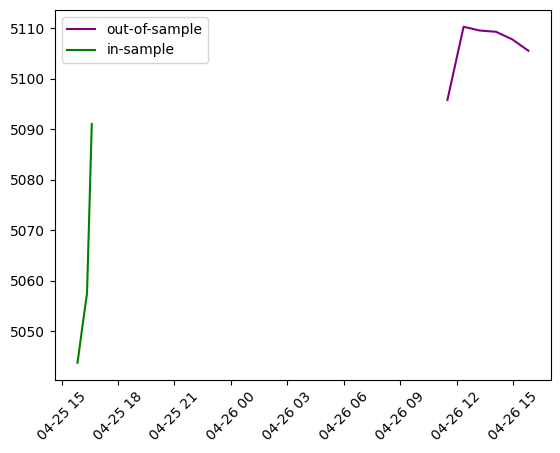

8350 8350


In [20]:

# development_dates = dates[:len(dates)//3]
# development_dates = dates[dates<=pd.Timestamp(2008,9,1)]
development_dates = dates[:4]

test_dates = dates[~dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]

train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()

trainplotx = pd.date_range(start=min(train_plot.index),end=max(train_plot.index),periods=len(train_plot))
testplotx = pd.date_range(start=min(test_plot.index),end=max(test_plot.index),periods=len(test_plot))

plt.figure()
plt.xticks(rotation=45)
plt.plot(testplotx,test_plot,color='purple',label='out-of-sample')
plt.plot(trainplotx,train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
print(len(train_y),len(train_X))

## stacked regressor

In [30]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [31]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 'barrier',
    'v0',
    'theta',
    'kappa',
]



ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)

ridge_pipeline = make_pipeline(ridge_preprocessor, RidgeCV())

test_ridge = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

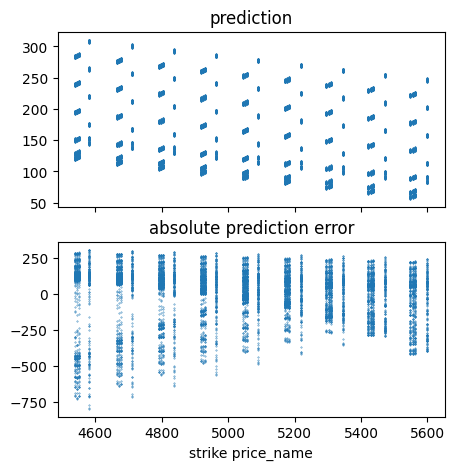


train spots:
calculation_date
2024-04-25 15:50:43.380   5043.75000
2024-04-25 16:00:35.484   5050.75000
2024-04-25 16:01:17.527   5057.50000
2024-04-25 16:36:12.970   5091.00000
Name: spot_price, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'barrier',
                                                                                        'v0',
                                                                                        'theta',
                                                                                        'kappa'])])),
                                                     ('ridgecv', RidgeCV())]),
                           transformer=StandardScaler())

In [32]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price_name')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_scaler,trainer.numerical_features),
        ('categorical',OneHotEncoder(),trainer.categorical_features)
    ]
)

mlp_pipeline = make_pipeline(preprocessor,MLPRegressor())
stacked_regressor = StackingRegressor(estimators=[('dnn',mlp_pipeline),('ridge',ridge_pipeline)],final_estimator=GradientBoostingRegressor())
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
meta

TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('dnn',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('numerical',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                                       'kappa',
                                                                                                                       'theta',
                                                                                                                       'rho',
                                                                                                                       'eta',
                                                                                                                       'v0',
                                                                                                                       'barrier']),
                                                                                                                     ('categorical',
                                                                                                                      OneHotEncoder(),
                                                                                                                      ['barrier_type_name'...
                                                                                    ('mlpregressor',
                                                                                     MLPRegressor())])),
                                                                   ('ridge',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('scaling',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                                       'barrier',
                                                                                                                       'v0',
                                                                                                            

In [34]:
meta.fit(train_X,train_y)
P = meta.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
print(f"MAE: {MAE}\nRMSE: {RMSE}")

cpu: 149.03984880447388
MAE: 15.113865677028002
RMSE: 20.099952131347635


In [35]:
testP = meta.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

MAE: 656.6823414188502
RMSE: 720.5287982786899


### versus original

In [38]:
dnn = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
P = dnn.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"\n\nin sample:\nMAE: {MAE}\nRMSE: {RMSE}")


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 1000
warm_start: True
tol: 0.0001
cpu: 0.8209102153778076


in sample:
MAE: 15.25482708856581
RMSE: 20.823347838480693


In [37]:
testP = dnn.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

MAE: 372.50976095443076
RMSE: 475.017329580838
